In [1]:
from matplotlib import pyplot as plt 
import numpy as np 
import pandas as pd
import sys
sys.path.append('../')
from sklearn.metrics import r2_score
from matplotlib import gridspec, patches
from matplotlib import dates as mdates
import seaborn as sns
import shap

# Define mean quantile loss
def mean_qloss(y_true, y_pred, alpha):  
  if (alpha > 0) and (alpha < 1):
    residual = y_true - y_pred 
    return (residual * (alpha - (residual<0))).mean()
  else:
    return np.nan

# Setup version and area
version = '2021-08-20'
areas = ['DE']
area= 'DE'
area_names = ['Germany']

# Models for fig. 2 and 3
analysis_model_type_infos = {
    'gtb_day_ahead_l2':{
        'loss':'l2',
        'data_suffix':'_day_ahead',
        'name':'Day-ahead',
        'alpha':1,
    },
    'gtb_extended_l2':{
        'loss':'l2',
        'data_suffix':'_extended',
        'name':'Extended',
        'alpha':1,
    },
    'gtb_full_l2':{
        'loss':'l2',
        'data_suffix':'_full',
        'name':'Full',
        'alpha':1,
    },
    'daily_profile':{
        'name':'Daily profile',
    }

}

# Models for for fig 4
forecast_model_type_infos = {
    'gtb_day_ahead_l2':{
        'loss':'l2',
        'data_suffix':'_day_ahead',
        'name':'Day-ahead',
        'alpha':1,
    },
    'gtb_day_ahead_igcc_l2':{
        'loss':'l2',
        'data_suffix':'_day_ahead_igcc',
        'name':'Day-ahead with IGCC',
        'alpha':1
    },
    'gtb_extended_l2':{
        'loss':'l2',
        'data_suffix':'_extended',
        'name':'Extended',
        'alpha':1,
    },    
    'gtb_day_ahead_q90':{
        'loss':'quantile',
        'data_suffix':'_day_ahead',
        'name':'Day-ahead',
        'alpha':0.9
    },
    'gtb_day_ahead_igcc_q90':{
        'loss':'quantile',
        'data_suffix':'_day_ahead_igcc',
        'name':'Day-ahead with IGCC',
        'alpha':0.9
    },
    'gtb_extended_q90':{
        'loss':'quantile',
        'data_suffix':'_extended',
        'name':'Extended',
        'alpha':0.9
    }
}

# Models for fig. 6
quantile_model_type_infos = {
    'gtb_day_ahead_q90':{
        'loss':'quantile',
        'data_suffix':'_day_ahead',
        'name':'Day-ahead',
        'alpha':0.9
    },
    'gtb_extended_q90':{
        'loss':'quantile',
        'data_suffix':'_extended',
        'name':'Extended',
        'alpha':0.9
    },
    'gtb_full_q90':{
        'loss':'quantile',
        'data_suffix':'_full',
        'name':'Full',
        'alpha':0.9
    },
}

# Folder setup
# Root directory of notebook is assumed to be the repository directory
data_folder = './data/{}/'
version_folder = './data/{}/version_{}/'
fit_folder = './results/model_fit/{}/version_{}/target_{}/'
figure_path = './../../Papers/afrr_prediction_germany/figures/'

# All possible features
input_cols = ['gen_other', 'gen_solar', 'gen_wind_on', 'gen_waste', 'gen_nuclear',
       'gen_biomass', 'gen_gas', 'gen_run_off_hydro', 'gen_oil',
       'gen_pumped_hydro', 'gen_other_renew', 'gen_reservoir_hydro',
       'gen_hard_coal', 'gen_wind_off', 'gen_geothermal', 'gen_lignite',
       'load', 'gen_coal_gas', 'total_gen', 'synchronous_gen', 'load_ramp',
       'total_gen_ramp', 'other_ramp', 'solar_ramp', 'wind_on_ramp',
       'waste_ramp', 'nuclear_ramp', 'biomass_ramp', 'gas_ramp',
       'run_off_hydro_ramp', 'oil_ramp', 'pumped_hydro_ramp',
       'other_renew_ramp', 'reservoir_hydro_ramp', 'hard_coal_ramp',
       'wind_off_ramp', 'geothermal_ramp', 'lignite_ramp', 'coal_gas_ramp',
       'forecast_error_wind_on', 'forecast_error_wind_off',
       'forecast_error_solar', 'forecast_error_total_gen',
       'forecast_error_load', 'forecast_error_load_ramp',
       'forecast_error_total_gen_ramp', 'forecast_error_wind_off_ramp',
       'forecast_error_wind_on_ramp', 'forecast_error_solar_ramp',
       'solar_day_ahead', 'wind_on_day_ahead', 'scheduled_gen_total',
       'prices_day_ahead', 'load_day_ahead', 'wind_off_day_ahead', 'month',
       'weekday', 'hour', 'load_ramp_day_ahead', 'total_gen_ramp_day_ahead',
       'wind_off_ramp_day_ahead', 'wind_on_ramp_day_ahead',
       'solar_ramp_day_ahead', 'price_ramp_day_ahead','gen_fossil_peat','fossil_peat_ramp', 'residual',
       'import_export_day_ahead', 'import_export_ramp_day_ahead', 'cross_border_flow', 'cross_border_flow_ramp',
       'forecast_error_flow', 'forecast_error_flow_ramp', 'pumped_hydro_consumption', 'pumped_hydro_consumption_ramp',
       'import_export_total', 'import_export_total_ramp', 'unscheduled_flow', 'unscheduled_flow_ramp',
       'load_ramp_igcc_day_ahead', 'total_gen_ramp_igcc_day_ahead', 'wind_off_ramp_igcc_day_ahead',
       'wind_on_ramp_igcc_day_ahead', 'solar_ramp_igcc_day_ahead',  'price_ramp_igcc_day_ahead',
       'load_igcc_day_ahead', 'scheduled_gen_total_igcc', 'wind_off_igcc_day_ahead',
       'wind_on_igcc_day_ahead', 'solar_igcc_day_ahead',  'price_igcc_day_ahead']

# Names for the features
input_col_names = ['Generation other', 'Solar generation', 'Onshore wind generation', 'Waste generation',
                   'Nuclear generation',
       'Biomass generation', 'Gas generation', 'Run-off-river hydro generation', 'Oil generation',
       'Pumped hydro generation', 'Other renewable generation', 'Reservoir hydro generation',
       'Hard coal generation', 'Wind offshore generation', 'Geothermal generation', 'Lignite generation',
       'Load', 'Coal gas generation', 'Total generation', 'Synchronous generation', 'Load ramp',
       'Total generation ramp', 'Other ramp', 'Solar ramp', 'Onshore wind ramp',
       'Waste ramp', 'Nuclear ramp', 'Biomass ramp', 'Gas ramp',
       'Run-off-river hydro ramp', 'Oil ramp', 'Pumped hydro ramp',
       'Other renewable ramp', 'Reservoir hydro ramp', 'Hard coal ramp',
       'Offshore wind ramp', 'geothermal_ramp', 'Lignite ramp', 'Coal gas ramp',
       'Forecast error onshore wind', 'Forecast error offshore wind',
       'Forecast error solar', 'Forecast error total generation',
       'Forecast error load', 'Forecast error load ramp',
       'Forecast error generation ramp', 'Forecast error offshore wind ramp',
       'Forecast error onshore wind ramp', 'Forecast error solar ramp',
       'Solar day-ahead', 'Onshore wind day-ahead', 'Scheduled generation',
       'Prices day-ahead', 'Load day-ahead', 'Offshore wind day-ahead', 'Month',
       'Weekday', 'Hour', 'Load ramp day-ahead', 'Generation ramp day-ahead',
       'Offshore wind ramp day-ahead', 'Onshore wind ramp day-ahead',
       'Solar ramp day-ahead', 'Price ramp day-ahead', 'Fossil peat generation', 'Fossil peat ramp', 'Residual',
       'Scheduled flow day-ahead', 'Scheduled flow ramp day-ahead', 'Physical flow', 'Physical flow ramp',
       'Forecast error flow', 'Forecast error flow ramp', 'Pumped hydro consumption', 'Pumped hydro consumption ramp',
       'Total scheduled flow', 'Total scheduled flow ramp', 'Unscheduled flow', 'Unscheduled flow ramp',
       'Load ramp day-ahead (IGCC)', 'Generation ramp day-ahead (IGCC)', 'Offshore wind ramp day-ahead (IGCC)',
       'Onshore wind ramp day-ahead (IGCC)', 'Solar ramp day-ahead (IGCC)',  'Price ramp day-ahead (IGCC)',
       'Load day-ahead (IGCC)', 'Scheduled generation (IGCC)', 'Offshore wind day-ahead (IGCC)',
       'Onshore wind day-ahead (IGCC)', 'Solar day-ahead (IGCC)',  'Price day-ahead (IGCC)']

# feature names with units
input_col_names_units_general = ['Generation other [GW]', 'Solar generation [GW]', 'Onshore wind generation [GW]', 
        'Waste generation [GW]', 'Nuclear generation [GW]',
       'Biomass generation [GW]', 'Gas generation [GW]', 'Run-off-river hydro generation [GW]', 'Oil generation [GW]',
       'Pumped hydro generation [GW]', 'Other renewable generation [GW]', 'Reservoir hydro generation [GW]',
       'Hard coal generation [GW]', 'Wind offshore generation [GW]', 'Geothermal generation [GW]', 
       'Lignite generation [GW]',
       'Load [GW]', 'Coal gas generation [GW]', 'Total generation [GW]', 'synchronous_gen [GW]', 'Load ramp [GW/h]',
       'Total generation ramp [GW/h]', 'Other ramp [GW/h]', 'Solar ramp [GW/h]', 'Onshore wind ramp [GW/h]',
       'Waste ramp [GW/h]', 'Nuclear ramp [GW/h]', 'Biomass ramp [GW/h]', 'Gas ramp [GW/h]',
       'Run-off-river hydro ramp [GW/h]', 'Oil ramp [GW/h]', 'Pumped hydro ramp [GW/h]',
       'Other renewables ramp [GW/h]', 'Reservoir hydro ramp [GW/h]', 'Hard coal ramp [GW/h]',
       'Offshore wind ramp [GW/h]', 'geothermal_ramp [GW/h]', 'Lignite ramp [GW/h]', 'coal_gas_ramp [GW/h]',
       'Forecast error onshore wind [GW]', 'Forecast error offshore wind [GW]',
       'Forecast error solar [GW]', 'Forecast error total generation [GW]',
       'Forecast error load [GW]', 'Forecast error load ramp [GW]',
       'Forecast error generation ramp [GW/h]', 'Forecast error offshore wind ramp [GW/h]',
       'Forecast error onshore wind ramp [GW/h]', 'Forecast error solar ramp [GW/h]',
       'Solar day-ahead [GW]', 'Onshore wind day-ahead [GW]', 'Scheduled generation [GW]',
       'Prices day-ahead [€/MWh]', 'Load day-ahead [GW]', 'Offshore wind day-ahead [GW]', 'Month',
       'Weekday', 'Hour', 'Load ramp day-ahead [GW/h]', 'Generation ramp day-ahead [GW/h]',
       'Offshore wind ramp day-ahead [GW/h]', 'Onshore wind ramp day-ahead [GW/h]',
       'Solar ramp day-ahead [GW/h]', 'Price ramp day-ahead [€/MWh/h]','Fossil peat generation [GW]', 
       'Fossil peat ramp [GW/h]', 'Residual',
       'Scheduled flow day-ahead [GW]', 'Scheduled flow ramp day-ahead [GW/h]', 'Physical flow [GW]', 
       'Physical flow ramp [GW]','Forecast error flow [GW]',
       'Forecast error flow ramp [GW/h]', 'Pumped hydro consumption [GW]', 'Pumped hydro consumption ramp [GW/h]',
       'Total scheduled flow [GW]', 'Total scheduled flow ramp [GW/h]', 'Unscheduled flow [GW]',
       'Unscheduled flow ramp [GW/h]',
       'Load ramp day-ahead (IGCC)[GW/h]', 'Generation ramp day-ahead (IGCC)[GW/h]', 
       'Offshore wind ramp day-ahead (IGCC)[GW/h]',
       'Onshore wind ramp day-ahead (IGCC)[GW/h]', 'Solar ramp day-ahead (IGCC)[GW/h]',  
       'Price ramp day-ahead (IGCC)[€/MWh/h]',
       'Load day-ahead (IGCC)[GW]', 'Scheduled generation (IGCC)[GW]', 'Offshore wind day-ahead (IGCC)[GW]',
       'Onshore wind day-ahead (IGCC)[GW]', 'Solar day-ahead (IGCC)[GW]',  'Price day-ahead (IGCC)[€/MWh]']

input_col_names = dict(zip(input_cols, input_col_names))
input_col_names_units = dict(zip(input_cols, input_col_names_units_general))


# Rescale factors 
input_rescale_factors = pd.Series(index=input_cols, data=1/1000) # Rescale from MW to GW
input_rescale_factors.loc[['weekday', 'hour','month', 'prices_day_ahead',
                           'price_ramp_day_ahead', 'price_igcc_day_ahead', 'price_ramp_igcc_day_ahead']]=1
gen_ramp_cols = input_rescale_factors.filter(regex='ramp').index
input_rescale_factors.loc[gen_ramp_cols]= input_rescale_factors.loc[gen_ramp_cols]*4 # Due to 15min resolution

# Target names
targets = ['AFRR_DE_POS', 'AFRR_DE_NEG']
target_names= ['Positive aFRR', 'Negative aFRR']
target_names=dict(zip(targets, target_names))

# Colors for 4 different models
model_colors = sns.color_palette('magma_r', 4)
model_colors = dict(zip(['Day-ahead', 'Extended', 'Full', 'Daily profile'], model_colors))
model_colors['Day-ahead with IGCC'] = model_colors['Day-ahead']



# Figure 1

In [2]:
# Retrain GBT regressor

from lightgbm import LGBMRegressor

target='AFRR_DE_POS'
y_train = pd.read_hdf(version_folder.format(area,version)+'y_train.h5').loc[:, target]
X_train = pd.read_hdf(version_folder.format(area,version)+'X_train_extended.h5')
X_test = pd.read_hdf(version_folder.format(area,version)+'X_test_extended.h5') 

best_params = pd.read_csv(fit_folder.format(area,version, target)+'cv_best_params_gtb_extended_l2.csv',
                          usecols = ['n_estimators','num_leaves', 'max_depth', 'subsample', 'learning_rate',
                                     'min_child_samples',
                                     'objective', 'min_child_weight','subsample_freq','alpha', 'n_jobs'])
best_params = best_params.to_dict('records')[0]
best_params['n_jobs'] = 5


# Train on whole training set (including validation set)
model = LGBMRegressor(**best_params)
model.fit(X_train, y_train)
            
# Calculate SHAP values on test set
print('SHAP values analysis...')
expl = shap.Explainer(model)

SHAP values analysis...


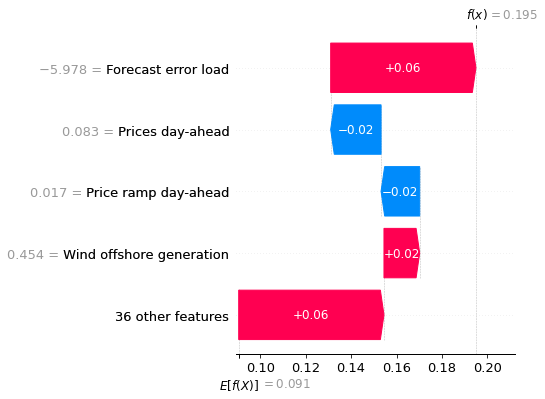

In [3]:
# Sektch of SHAP values

plt.figure(figsize=(3,5))
plt.subplot(1,1,1)
shap_vals = expl(X_test.loc['2021-04-15 06:00:00'].rename(columns=input_col_names))/1000
shap.plots.waterfall(shap_vals[0], show=False, max_display=5)
plt.gca().figure.set_size_inches(5, 6)

plt.savefig(figure_path+'shap_sketch.pdf', bbox_inches='tight')

In [3]:
# Strings with features contained in the models 

model_type_features = {'day_ahead':[], 'extended':[], 'full':[]}
model_type_features['day_ahead'] =  '- Day-ahead ...' +\
                                    '\n...load forecast' +\
                                    '\n...wind/solar power forecast' +\
                                    '\n...scheduled generation' +\
                                    '\n...scheduled flow ' +\
                                    '\n...prices' +\
                                    '\n- Hour, Weekday'
    



model_type_features['extended'] = '- Actual load \n- Actual wind and \nsolar power \ngeneration \n- Physical flows \n- Forecast errors'


model_type_features['full'] = '- Actual \ndispatchable \ngeneration \nper type \n(Hard coal, \nnuclear, \nhydro, ...) '

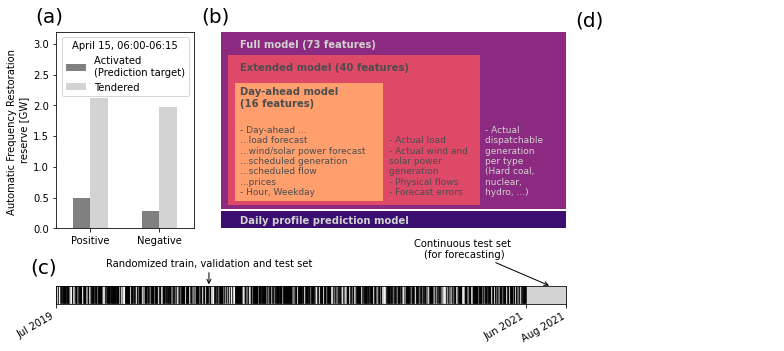

In [9]:
fig = plt.figure( figsize=(11,5))
width_ratios=[0.6,1.5,0.8]
height_ratios=[1,0.09]
gs = gridspec.GridSpec(2, 3, width_ratios=width_ratios, height_ratios=height_ratios)

#### Visualization of target data 

ax = plt.subplot(gs[0,0])

dt='2021-04-15 06:00:00'
y_test = pd.read_hdf(version_folder.format(area, version)+'y_test.h5')
afrr_vals = y_test.loc[dt].squeeze().to_frame('Activated \n(Prediction target)')
afrr_vals['Tendered'] = pd.read_hdf('./data/DE/afrr_demand.h5').loc[y_test.loc[dt].index[0]]
afrr_vals = afrr_vals.rename(index=dict(zip(targets,  ['Positive','Negative'])))

pats = afrr_vals.div(1000).plot.bar(ax=ax, color={'Tendered':'lightgrey', 'Activated \n(Prediction target)':'grey'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.set_ylabel('Automatic Frequency Restoration \nreserve [GW]')
leg=ax.legend(title='April 15, 06:00-06:15', fontsize=10)
ax.annotate('(a)', (-0.15,1.05),  xycoords='axes fraction', fontsize=20)
ax.set_ylim([0,3.2])

#### Visualization of models 

ax = plt.subplot(gs[0,1])

full_set = patches.Rectangle((0.,0.1), 1, 0.91,  fc=model_colors['Full'])
extended_set = patches.Rectangle((0.02,0.12), 0.73, 0.76, fc=model_colors['Extended'])
dayahead_set = patches.Rectangle((0.04,0.14), 0.43, 0.6, fc=model_colors['Day-ahead'])
daily_profile_set = patches.Rectangle((0.0,0.), 1, 0.09,  fc=model_colors['Daily profile'])

ax.add_artist(full_set)
ax.add_artist(extended_set)
ax.add_artist(dayahead_set)
ax.add_artist(daily_profile_set)

cgrey = sns.color_palette("Greys", 20)
ax.annotate('Full model (73 features)', (0.055,0.92), fontweight='bold', c=cgrey[5])
ax.annotate('Extended model (40 features)', (0.055,0.8),fontweight='bold', c=cgrey[15])
ax.annotate('Day-ahead model \n(16 features)', (0.055,0.62),fontweight='bold', c=cgrey[15])
ax.annotate('Daily profile prediction model', (0.055,0.025),fontweight='bold', c=cgrey[5])
ax.annotate(model_type_features['day_ahead'], (0.055, 0.17), fontsize=9, c=cgrey[15])
ax.annotate(model_type_features['extended'], (0.485, 0.17), fontsize=9, c=cgrey[15])
ax.annotate(model_type_features['full'], (0.765, 0.17), fontsize=9, c=cgrey[5])

ax.axis('off')
ax.annotate('(b)', (-0.1/1.7,1.05),  xycoords='axes fraction', fontsize=20)

##### Here the SHAP sketch will be inserted

ax = plt.subplot(gs[:,2])
ax.axis('off')
ax.annotate('(d)', (-0.1,1.05/1.03), xycoords='axes fraction', fontsize=20)

##### Visualization of Train-test splits

ax = plt.subplot(gs[1, :2])

full_index= pd.date_range(start = pd.Timestamp('2019-07-01 00:00:00'), end = pd.Timestamp('2021-06-01 00:00'), freq='1d')
cont_index= pd.date_range(start = pd.Timestamp('2021-06-01 00:00'), end = pd.Timestamp('2021-07-31 00:00'), freq='1d')
vals = np.random.choice(a=['train', 'val', 'test'], size=full_index.shape[0], p=[0.64, 0.16, 0.2])
val_colors = {'train':'k', 'val':'w', 'test':'grey'}

for i,val in enumerate(vals):
    ax.plot((full_index[i],full_index[i]), (0,1), c=val_colors[val])
ax.fill_between((cont_index[0], cont_index[-1]), (0,0), (1,1), color='lightgrey')
ax.set_xlim(full_index[0], cont_index[-1])
ax.set_xticks([full_index[0], cont_index[0], cont_index[-1]])
ax.set_xticklabels(['Jul 2019', 'Jun 2021', 'Aug 2021'], rotation=30, ha='right')
ax.annotate('(c)', (-0.15/3,1.05/0.6),  xycoords='axes fraction', fontsize=20)
ax.get_yaxis().set_visible(False)
plt.tight_layout()

ax.annotate('Randomized train, validation and test set', xy=(0.3, 1), xytext=(0.3, 2), xycoords='axes fraction',
            arrowprops=dict(arrowstyle='->', lw=1),ha='center', va='bottom') 
ax.annotate('Continuous test set \n(for forecasting)', xy=(0.97, 1), xytext=(0.8, 2.5), xycoords='axes fraction',
            arrowprops=dict(arrowstyle='->', lw=1),ha='center', va='bottom') 

plt.savefig(figure_path+'fig1_start.pdf', bbox_inches='tight')

# Figure 2

               Day-ahead  Extended      Full  Daily profile
Positive aFRR   0.445876  0.482922  0.628751       0.047660
Negative aFRR   0.475742  0.504992  0.604107       0.039214


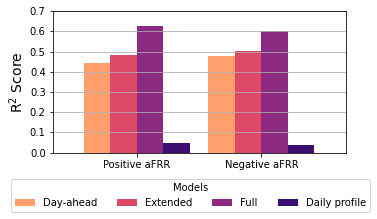

In [128]:
# R2 performance on randomized test set

fig,ax=plt.subplots(figsize=(5,2.5), sharey=True)

predictors= list(analysis_model_type_infos.keys())
model_names =  {model_type : analysis_model_type_infos[model_type]['name'] for model_type in predictors}
scores = pd.DataFrame(index=targets, columns=predictors, dtype='float')
    
for j,targ in enumerate(targets):
    y_test = pd.read_hdf(version_folder.format(area,version)+'y_test.h5').loc[:,targ]
    y_pred = pd.read_hdf(fit_folder.format(area,version,targ)+'y_pred_test.h5')
    scores.loc[targ] = [r2_score(y_test, y_pred.loc[:,model_type]) for model_type in scores.columns]
    
scores = scores.rename(index=target_names, columns=model_names)
scores.plot.bar(ylim=[-0.02,scores.max().max()+0.05], width=0.85, ax=ax, legend=False, color=model_colors)
ax.set_xticks(np.arange(len(targets)))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.grid(axis='y')
print(scores)

ax.set_ylabel(r'R$^2$ Score', fontsize=14)
ax.set_ylim([0,0.7])
plt.tight_layout()

leg1 = ax.legend(fontsize=10, bbox_to_anchor=(1.1,-0.15), ncol=4, title='Models')  

plt.savefig(figure_path+'fig2.pdf', bbox_inches='tight')

In [129]:
# R2 Performance of models on continuous test set

predictors= list(analysis_model_type_infos.keys())
scores = pd.DataFrame(index=targets, columns=predictors, dtype='float')
    
for j,targ in enumerate(targets):
    y_test = pd.read_hdf(version_folder.format(area,version)+'y_cont.h5').loc[:,targ]
    y_pred = pd.read_hdf(fit_folder.format(area,version,targ)+'y_pred_cont.h5')
    scores.loc[targ] = [r2_score(y_test, y_pred.loc[:,model_type]) for model_type in scores.columns]
    
scores = scores.rename(index=target_names, columns=model_names)
print(scores)

               Day-ahead  Extended      Full  Daily profile
Positive aFRR  -0.142598  0.114279  0.374395       0.038809
Negative aFRR  -0.391685 -0.098420  0.173689      -0.096708


# Figure 3

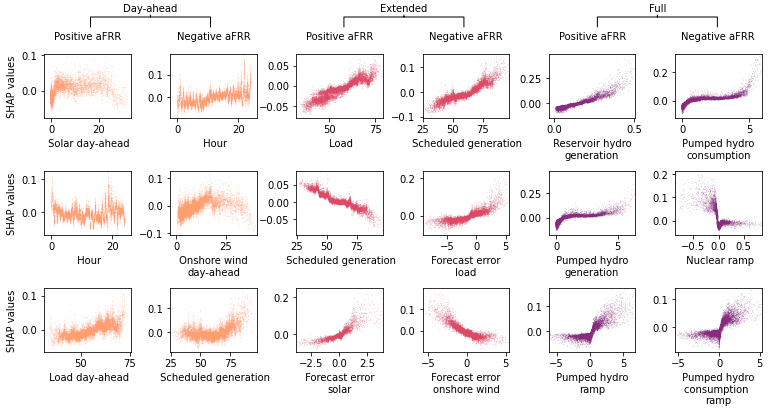

In [13]:
n_features = 3
fig,ax = plt.subplots(3,6,figsize=(11,5.5))


for i, (model_type, model_infos) in enumerate(analysis_model_type_infos.items()):

    if model_type!='daily_profile':
        
        X_test = pd.read_hdf(version_folder.format(area, version)+'X_test{}.h5'.format(model_infos['data_suffix']))
        X_test = X_test.mul(input_rescale_factors.loc[X_test.columns]).rename(columns=input_col_names)
        
        for k,targ in enumerate(targets):  

            shap_vals = np.load(fit_folder.format(area, version, targ)+ 'shap_values_test_{}.npy'.format(model_type))/1000
            shap_vals = pd.DataFrame(index=X_test.index, columns=X_test.columns, data=shap_vals)
            important_features = shap_vals.abs().mean().sort_values(ascending=False).index[:n_features]
            
            for j, name in enumerate(important_features):

                xlower = X_test.loc[:,name].quantile(0.005)
                xupper =  X_test.loc[:,name].quantile(0.995)
                ylower = pd.Series(shap_vals.loc[:,name]).quantile(0.001)
                yupper =  pd.Series(shap_vals.loc[:,name]).quantile(0.999)

                im=ax[j,k+i*2].plot(X_test.loc[:,name],shap_vals.loc[:,name], '.', ms=0.09, rasterized=True,
                                    c=model_colors[model_infos['name']]) 
                ax[j,k+i*2].set_xlim([xlower-np.abs(xupper-xlower)*0.1,xupper+np.abs(xupper-xlower)*0.1])
                ax[j,k+i*2].set_ylim([ylower-np.abs(yupper-ylower)*0.1,yupper+np.abs(yupper-ylower)*0.1])
                ax[j,0].set_ylabel('SHAP values', fontsize=10)
                
                # Add line breaks to feature names
                name_words = name.split()
                newline_name = '' 
                for word in name_words:

                    if len(newline_name.split('\n')[-1])>10:
                        newline_name += ' \n'+word
                    else:
                        newline_name += ' '+word
                ax[j,k+i*2].set_xlabel(newline_name, fontsize=10)
                
            ax[0,k+i*2].set_title(target_names[targ], fontsize=10, pad=15)


fig.tight_layout(w_pad=0.2)
plt.annotate('Day-ahead', xy=(0.19, 1), xytext=(0.19, 1.01), xycoords='figure fraction', 
             ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=1.', lw=1.0)) 
plt.annotate('Extended', xy=(0.51, 1), xytext=(0.51, 1.01), xycoords='figure fraction', 
             ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=1.', lw=1.0)) 
plt.annotate('Full', xy=(0.83, 1), xytext=(0.83, 1.01), xycoords='figure fraction', 
            ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=1.', lw=1.0)) 

plt.savefig(figure_path+'fig3.pdf'.format(10+k), bbox_inches='tight', dpi=200)


# Figure 4

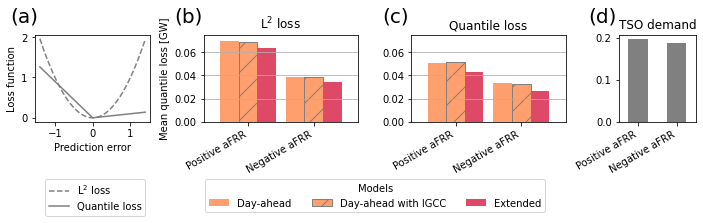

In [3]:

qloss = lambda x, q: x * (q - (x<0)) # x=y_ture - y_pred
l2loss = lambda x: x**2

fig, ax = plt.subplots(1,4, figsize=(10,3.2), gridspec_kw={'width_ratios':[1.5,2,2,1]})

# loss function

xs = np.arange(-1.4,1.4,0.01)
ax[0].plot(xs, l2loss(-xs), '--', label='L$^2$ loss', c='grey')
ax[0].plot(xs, qloss(-xs, q=0.9), label='Quantile loss', c='grey')
ax[0].set_ylabel('Loss function')
ax[0].legend()
ax[0].set_xlabel('Prediction error')
ax[0].annotate('(a)', (-0.21,1.15),  xycoords='axes fraction', fontsize=20)

# performance of l2 models 

predictors= list(forecast_model_type_infos.keys())
model_names =  {model_type : forecast_model_type_infos[model_type]['name'] for model_type in predictors}
scores = pd.DataFrame(index=targets, columns=predictors, dtype='float')
    
for j,targ in enumerate(targets):
    y_test = pd.read_hdf(version_folder.format(area,version)+'y_cont.h5').loc[:,targ]/1000
    y_pred = pd.read_hdf(fit_folder.format(area,version,targ)+'y_pred_cont.h5')/1000
    scores.loc[targ] = [mean_qloss(y_test, y_pred.loc[:,model_type], alpha=0.9) for model_type in scores.columns]
    
scores_l2 = scores.filter(regex='l2').rename(index=target_names, columns=model_names)
pats = scores_l2.plot.bar( width=0.85, ax=ax[1], legend=False, color=model_colors)
pats.get_children()[2].set_hatch('/')
pats.get_children()[2].set_edgecolor('grey')
pats.get_children()[3].set_hatch('/')
pats.get_children()[3].set_edgecolor('grey')
ax[1].set_xticks(np.arange(len(targets)))
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30, ha='right')
ax[1].grid(axis='y')
ax[1].set_title('L$^2$ loss')
ax[1].set_ylabel('Mean quantile loss [GW]')
ax[1].set_ylim([-0.0,0.075])
ax[1].annotate('(b)', (-0.19,1.15),  xycoords='axes fraction', fontsize=20)

# performance of q-models

scores_q90 = scores.filter(regex='q90').rename(index=target_names, columns=model_names)
pats = scores_q90.plot.bar(width=0.85, ax=ax[2], legend=True, color=model_colors, lw=1)
pats.get_children()[2].set_hatch('/')
pats.get_children()[2].set_edgecolor('grey')
pats.get_children()[3].set_hatch('/')
pats.get_children()[3].set_edgecolor('grey')
ax[2].set_xticks(np.arange(len(targets)))
ax[2].set_xticklabels(ax[1].get_xticklabels(), rotation=30, ha='right')
ax[2].grid(axis='y')
ax[2].set_ylim([-0.0,0.075])
ax[2].set_title('Quantile loss')
ax[2].annotate('(c)', (-0.19,1.15),  xycoords='axes fraction', fontsize=20)


# performance of tendered demands

scores = pd.DataFrame(index=targets, columns=['Tendered demand'], dtype='float')
for j,targ in enumerate(targets):
    y_test = pd.read_hdf(version_folder.format(area,version)+'y_cont.h5').loc[:,targ]/1000
    y_pred = pd.read_hdf('./data/DE/afrr_demand.h5').loc[y_test.index, targ]/1000
    scores.loc[targ] = mean_qloss(y_test, y_pred, alpha=0.9)
scores.rename(index=target_names).plot.bar(ax=ax[3], legend=False, color='grey')
ax[3].set_title('TSO demand')
ax[3].annotate('(d)', (-0.4,1.15),  xycoords='axes fraction', fontsize=20)

plt.tight_layout(w_pad=1)
ax[0].legend(bbox_to_anchor=(1,-0.6))
ax[2].legend(bbox_to_anchor=(0.9,-0.6), title='Models', ncol=3)
ax[3].set_xticklabels(ax[1].get_xticklabels(), rotation=30, ha='right')

plt.savefig(figure_path+'fig4.pdf', bbox_inches='tight', dpi=200)


# Figure 5

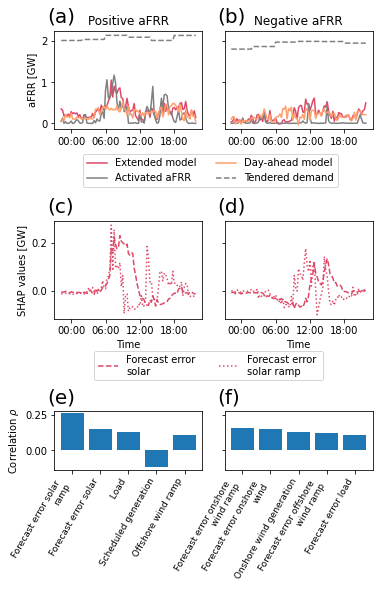

In [87]:

demand = pd.read_hdf('./data/DE/afrr_demand.h5')/1000
#fig, ax = plt.subplots(2,3, figsize=(9,4), sharey='row', sharex='col')
start='2021-07-14 00:10'
end='2021-07-14 23:45'

fig = plt.figure( figsize=(5.5,7.))
gs = fig.add_gridspec(3, 2, width_ratios = [1,1], height_ratios = [1,1,0.6])
ax2 = fig.add_subplot(gs[1,0])  
ax1 = fig.add_subplot(gs[0,0], sharex=ax2)
ax4 = fig.add_subplot(gs[1,1], sharey = ax2)   
ax3 = fig.add_subplot(gs[0,1], sharey = ax1, sharex=ax4)  
ax5 = fig.add_subplot(gs[2,0])  
ax6 = fig.add_subplot(gs[2,1], sharey = ax5)  

### Positive afrr
targ=targets[0]
y_pred_day_ahead = pd.read_hdf(fit_folder.format(area, version, targ)+ 'y_pred_cont.h5').loc[:, 'gtb_day_ahead_q90']/1000
y_pred_extended = pd.read_hdf(fit_folder.format(area, version, targ)+ 'y_pred_cont.h5').loc[:, 'gtb_extended_q90']/1000
y_test =  pd.read_hdf(version_folder.format(area, version)+'y_cont.h5').loc[:,targ]/1000
shap_vals = np.load(fit_folder.format(area, version, targ)+ 'shap_values_cont_gtb_extended_q90.npy')/1000
X_test = pd.read_hdf(version_folder.format(area, version)+'X_cont_extended.h5')
shap_vals = pd.DataFrame(index=X_test.index, columns=X_test.columns, data=shap_vals)

# model predictions
ax1.plot(y_pred_extended.loc[start:end], label='Extended', c=model_colors['Extended'])
ax1.plot(y_test.loc[start:end], label='Activated aFRR', c='grey')
ax1.plot(y_pred_day_ahead.loc[start:end], label='Day-ahead', c=model_colors['Day-ahead'])
ax1.plot(demand.loc[start:end, targ], ls='--', label='Tendered demand', c='grey')
ax1.set_title(target_names[targ])
        
# SHAP values    
ax2.plot(shap_vals.loc[start:end, 'forecast_error_solar'], label='Forecast error solar', c=model_colors['Extended'], ls='--')
ax2.plot(shap_vals.loc[start:end, 'forecast_error_solar_ramp'], label='Forecast error solar ramp', c=model_colors['Extended'], ls=':')
ax1.set_ylabel('aFRR [GW]')
ax2.set_ylabel('SHAP values [GW]')


### negative afrr
targ=targets[1]
y_pred_day_ahead = pd.read_hdf(fit_folder.format(area, version, targ)+ 'y_pred_cont.h5').loc[:, 'gtb_day_ahead_q90']/1000
y_pred_extended = pd.read_hdf(fit_folder.format(area, version, targ)+ 'y_pred_cont.h5').loc[:, 'gtb_extended_q90']/1000
y_test =  pd.read_hdf(version_folder.format(area, version)+'y_cont.h5').loc[:,targ]/1000
shap_vals = np.load(fit_folder.format(area, version, targ)+ 'shap_values_cont_gtb_extended_q90.npy')/1000
X_test = pd.read_hdf(version_folder.format(area, version)+'X_cont_extended.h5')
shap_vals = pd.DataFrame(index=X_test.index, columns=X_test.columns, data=shap_vals)

# model predictions
ax3.plot(y_pred_extended.loc[start:end], label='Extended model', c=model_colors['Extended'])
ax3.plot(y_test.loc[start:end], label='Activated aFRR', c='grey') 
ax3.plot(y_pred_day_ahead.loc[start:end], label='Day-ahead model', c=model_colors['Day-ahead'])
ax3.plot(demand.loc[start:end, targ], ls='--', label='Tendered demand', c='grey')
ax3.set_title(target_names[targ])
        
# SHAP values  
ax4.plot(shap_vals.loc[start:end, 'forecast_error_solar'], label='Forecast error \nsolar', c=model_colors['Extended'], ls='--')
ax4.plot(shap_vals.loc[start:end, 'forecast_error_solar_ramp'], label='Forecast error \nsolar ramp', c=model_colors['Extended'], ls=':')

ax2.set_xlabel('Time')
ax4.set_xlabel('Time')

for ax in [ax1,ax2,ax3,ax4]:
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator, show_offset=False, zero_formats=['%Y', '%b', '%d', '%H:%M', '%H:%M', '%S.%f'])
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)


ax1.annotate('(a)', (-0.05,1.09),  xycoords='axes fraction', fontsize=20)
ax3.annotate('(b)', (-0.05,1.09),  xycoords='axes fraction', fontsize=20)
ax2.annotate('(c)', (-0.05,1.09),  xycoords='axes fraction', fontsize=20)
ax4.annotate('(d)', (-0.05,1.09),  xycoords='axes fraction', fontsize=20)
ax5.annotate('(e)', (-0.05,1.12),  xycoords='axes fraction', fontsize=20)
ax6.annotate('(f)', (-0.05,1.12),  xycoords='axes fraction', fontsize=20)


plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax6.get_yticklabels(), visible=False)
plt.tight_layout(w_pad=0, h_pad=3.6)

# Correlations

for ax, targ in zip([ax5, ax6], targets):
    y_pred_day_ahead = pd.read_hdf(fit_folder.format(area, version, targ)+ 'y_pred_cont.h5').loc[:, 'gtb_day_ahead_q90']/1000
    y_pred_extended = pd.read_hdf(fit_folder.format(area, version, targ)+ 'y_pred_cont.h5').loc[:, 'gtb_extended_q90']/1000
    y_test =  pd.read_hdf(version_folder.format(area, version)+'y_cont.h5').loc[:,targ]/1000
    shap_vals = np.load(fit_folder.format(area, version, targ)+ 'shap_values_cont_gtb_extended_q90.npy')/1000
    X_test = pd.read_hdf(version_folder.format(area, version)+'X_cont_extended.h5')
    shap_vals = pd.DataFrame(index=X_test.index, columns=X_test.columns, data=shap_vals)

    corrs = shap_vals.corrwith((y_test-y_pred_day_ahead).clip(lower=0))
    corrs = corrs.loc[corrs.abs().sort_values().index[::-1][:5]].rename(index=input_col_names)
    ax.bar(np.arange(corrs.shape[0]), corrs.values, tick_label=corrs.index)
    
    ticklabel_names = []
    for name in ax.get_xticklabels():
        name_words = name.get_text().split()
        newline_name = '' 
        for word in name_words:

            if len(newline_name.split('\n')[-1])>16:
                newline_name += ' \n'+word
            else:
                newline_name += ' '+word
        ticklabel_names +=[newline_name]
    
    ax.set_xticklabels(ticklabel_names, ha='right', rotation=60, fontsize=9)

ax5.set_ylabel(r'Correlation $\rho$')


ax3.legend(bbox_to_anchor=(0.8,-0.2), ncol=2)
ax4.legend(bbox_to_anchor=(0.7,-0.27), ncol=2)


plt.savefig(figure_path+'fig5.pdf', bbox_inches='tight', dpi=200)


# Figure 6

In [45]:
model_names =  {model_type : quantile_model_type_infos[model_type]['name'] for model_type in quantile_model_type_infos.keys()}


# Number of most important features included from each area and target
n_features= 4

# Setup
shap_vals_abs=pd.DataFrame(index=input_cols, columns=pd.MultiIndex.from_product([targets,quantile_model_type_infos.keys()]))
important_features = []

# Create set of unique important features 
# (including n_features from ich area-target pair)

for model_type, model_info in quantile_model_type_infos.items():
    for i,targ in enumerate(targets):    

        X_test = pd.read_hdf(version_folder.format(area, version)+'X_test{}.h5'.format(model_info['data_suffix']))
        X_train = pd.read_hdf(version_folder.format(area, version)+'X_train{}.h5'.format(model_info['data_suffix']))
        shap_vals = np.load(fit_folder.format(area, version, targ)+ 'shap_values_test_{}.npy'.format(model_type))
        shap_vals = pd.DataFrame(data=shap_vals, index=X_test.index, columns=X_test.columns)
        
        shap_vals_abs.loc[:,(targ,model_type)] = shap_vals.abs().mean()
        
        important_features+= list(shap_vals.abs().mean().sort_values(ascending=False).iloc[:n_features].index)
        
important_features = np.unique(important_features)
shap_vals_abs = shap_vals_abs / shap_vals_abs.max()

shap_vals_abs = shap_vals_abs.rename(columns=model_names)
important_features

array(['forecast_error_load', 'forecast_error_solar',
       'forecast_error_solar_ramp', 'forecast_error_wind_off',
       'forecast_error_wind_on', 'forecast_error_wind_on_ramp',
       'gen_pumped_hydro', 'gen_reservoir_hydro', 'hour', 'load',
       'load_day_ahead', 'nuclear_ramp', 'prices_day_ahead',
       'pumped_hydro_consumption', 'pumped_hydro_consumption_ramp',
       'pumped_hydro_ramp', 'scheduled_gen_total', 'solar_day_ahead',
       'wind_off_day_ahead', 'wind_on_day_ahead'], dtype='<U29')

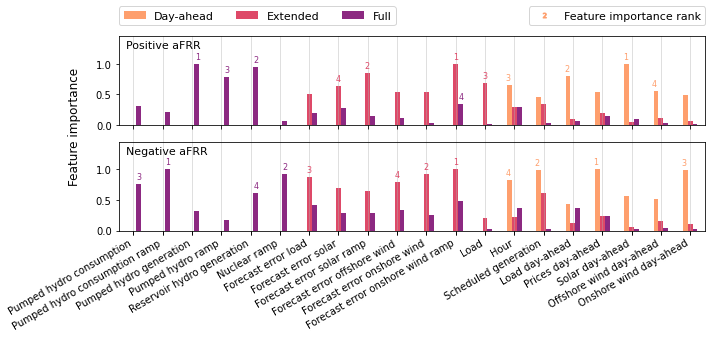

In [60]:
important_features = ['pumped_hydro_consumption', 'pumped_hydro_consumption_ramp', 
                      'gen_pumped_hydro', 'pumped_hydro_ramp', 'gen_reservoir_hydro', 'nuclear_ramp', 
                      'forecast_error_load', 'forecast_error_solar',
                      'forecast_error_solar_ramp', 'forecast_error_wind_off',
                      'forecast_error_wind_on', 'forecast_error_wind_on_ramp',
                      'load',  'hour',
                      'scheduled_gen_total','load_day_ahead', 'prices_day_ahead',
                      'solar_day_ahead', 'wind_off_day_ahead', 'wind_on_day_ahead']

fig, axs = plt.subplots(2,1,figsize=(10,5.))

# make feature importance bar plots
for i,targ in enumerate(targets):  
    shap_vals_abs.loc[important_features,targ].rename(index=input_col_names).plot(kind='bar', ax=axs[i],legend=False, color=model_colors)
    
    axs[i].set_ylim([0,1.45])
    
    # annotate n_features most important features with their importance rank 
    for j,(model_type, model_info) in enumerate(quantile_model_type_infos.items()):

        for m in range(n_features):
            feature_m = shap_vals_abs.loc[:,(targ, model_info['name'])].sort_values(ascending=False).iloc[[m]]
            idx = np.argwhere(shap_vals_abs.loc[important_features].index==feature_m.index[0])[0,0]
            axs[i].annotate(m+1, (idx-0.3 +j*0.2, feature_m.values+0.08), fontsize=8, c=model_colors[model_info['name']])

    # add axis labels and legend
    if i!=1:
        axs[i].set_xticklabels('')
    if i==1:
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=30, ha='right')
    if i==0:
        leg1 = axs[i].legend(bbox_to_anchor=(0.482,1.4), ncol=4,columnspacing=2, fontsize=11)
        annot_text = plt.plot(-10,0, marker=r'$2$', ms=5, lw=0,  c=model_colors['Day-ahead'])
        leg2 = axs[i].legend(annot_text, ['Feature importance rank'], bbox_to_anchor=(1.01,1.4), ncol=3,columnspacing=2, fontsize=11)
        axs[i].add_artist(leg1)
        
    # add target names    
    axs[i].grid(True, axis='x', alpha=0.5)
    axs[i].annotate(target_names[targ], (-0.25,1.25), fontsize=11)

fig.text(0.11, 0.6, 'Feature importance', va='center', ha='center', rotation='vertical', fontsize=12)



#Add grid between the subplots
ax3 = fig.add_subplot(111, zorder=-1, sharex=axs[0])
for _, spine in ax3.spines.items():
    spine.set_visible(False)
ax3.tick_params(labelleft=False, labelbottom=False, left=False, right=False )
ax3.grid(axis="x", alpha=0.5)

plt.tight_layout()
plt.savefig(figure_path+'fig6.pdf', bbox_inches='tight')